In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../scripts/')

from equiv_test_funcs import *


/Users/jolivie1/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jolivie1/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jolivie1/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def ttests(df):
    
    # run t tests from script (should be what's done in perform tests)

    if norm:
      # normalize each row (sample) by the number of counts
        df = normalize(df)

    if log_scale:
        df = log2_scale(df)

    plot = False

    # testing out function you can use in Python code
    # perform_tests_for_df(df, args.delta)

    out_df = loop_over_genes(df, delta, plot)

    out_df = process_out_df(out_df, delta)
    #display(out_df.head())
    return out_df["sig_diff"][0], out_df["sig_equiv"][0]




## Simulation description

2 populations (two different kinds of cell types)

There are only two genes (gene A and gene B)

We're taking `num_samples` samples from each population

Population 1/"cell type":
sample 1
sample 2 
sample 3

Population 2/"cell type":
sample 4
sample 5
sample 6

We're going to define the fraction of gene expression that is from gene A for each population

`geneA_fracs`: it's a list of length 2. The first entry is the fraction of gene A in population 1. The second entry entry is the fraction of gene A in population 2.

For example, if `geneA_fracs = [0.2, 0.8]` it means 20% of the gene expression is from gene A in population 1. So we might expect to have 22 counts from gene A and 83 counts from gene B in a sample from population 1.

For the second population, we might expect something like 79 counts from gene A and 18 from gene B.

The `numReads` list contains all the values of read numbers we want to test for. What I mean by read number: the number of "counts" we have for a given sample.

Additional parameters: when `norm = True` we normalize the scores just by dividing by the total number of reads. When `log_scale = True` we take the log of the count values.

`delta`: this is the equivalence testing parameter. When ` log_scale = True`, `delta = 1` tests for fold change.

In [3]:
outpath = "../plots/"

#numReads = [5, 10, 50, 100, 500, 1000]

numReads = [1, 2, 3, 4, 5]

#numReads = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]

num_trials = 10

num_samples = 3


geneA_fracs = [0.2, 0.8]


norm = True
log_scale = True

delta = 1
alpha = 0.05


In [4]:
np.random.seed(123)

out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
       "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
       "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

for num in numReads:
    print("num reads: {}".format(num))
    # collect p vals for each
    num_sig_diff = 0
    num_sig_equiv = 0
    num_inconclusive = 0
    
    for i in range(num_trials):
        data = {"sample" : [], "A" : [], "B" : [], "cell_type" : []}
        count = 0
        for j in range(len(geneA_fracs)):
            for k in range(num_samples):
                count += 1
                
                # add 1 so it's never zero
                n = np.random.poisson(num) + 1
                A = np.random.binomial(n, geneA_fracs[j])
                data["sample"].append("sample" + str(count))
                data["A"].append(A)
                data["B"].append(n - A)
                data["cell_type"].append(j)
        df = pd.DataFrame(data).set_index("sample")
        
        # get results
        diff_sig, equiv_sig = ttests(df)
        
        # save output
        num_sig_diff += diff_sig
        num_sig_equiv += equiv_sig
        num_inconclusive += 1 - diff_sig - equiv_sig
        
    # get frac significant
    out["numReads"].append(num)

#    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
    out["frac_sig_diff"].append(num_sig_diff/num_trials)
    out["frac_sig_diff_lower"].append(lower_ci)
    out["frac_sig_diff_upper"].append(upper_ci)

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
    out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
    out["frac_sig_equiv_lower"].append(lower_ci)
    out["frac_sig_equiv_upper"].append(upper_ci)
    

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
    out["frac_sig_inc"].append(num_inconclusive/num_trials)
    out["frac_sig_inc_lower"].append(lower_ci)
    out["frac_sig_inc_upper"].append(upper_ci)
out = pd.DataFrame(out)
display(out)

/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.666667
sample3    0.000000
sample4    1.000000
sample5    1.000000
sample6    1.000000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.333333
sample3    1.000000
sample4    0.000000
sample5    0.000000
sample6    0.000000
Name: B, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1]

num reads: 1


  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  diff_pval = stats.ttest_ind(a=group1_vals, b = group2_vals).pvalue
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 361.33it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.0
sample2    0.0
sample3    0.0
sample4    1.0
sample5    1.0
sample6    1.0
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a 

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 604.24it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.333333
sample2    0.000000
sample3    0.000000
sample4    1.000000
sample5    1.000000
sample6    0.666667
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.666667
sample2    1.000000
sample3    1.000000
sample4    0.000000
sample5    0.000000
sample6    0.3333

num reads: 2


  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  diff_pval = stats.ttest_ind(a=group1_vals, b = group2_vals).pvalue
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 778.53it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.500000
sample3    0.000000
sample4    1.000000
sample5    1.000000
sample6    0.666667
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.500000
sample3    1.000000
sample4    0.000000
sample5    0.000000
sample6    0.3333

num reads: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 809.09it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.000000
sample3    0.142857
sample4    0.666667
sample5    0.000000
sample6    1.000000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    1.000000
sample3    0.857143
sample4    0.333333
sample5    1.000000
sample6    0.0000

  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  diff_pval = stats.ttest_ind(a=group1_vals, b = group2_vals).pvalue
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 920.01it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.166667
sample2    0.000000
sample3    0.200000
sample4    0.750000
sample5    1.000000
sample6    1.000000
Name: A, dtype: float64' has dtype incompatible with int64

num reads: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 794.30it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.40
sample2    0.75
sample3    0.20
sample4    1.00
sample5    0.75
sample6    0.75
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.60
sample2    0.25
sample3    0.80
sample4    0.00
sample5    0.25
sample6    0.25
Name: B, dtype: float64' has dtype incompatib

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 801.59it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.0
sample2    0.0
sample3    0.0
sample4    1.0
sample5    1.0
sample6    0.5
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.0
sample2    1.0
sample3    1.0
sample4    0.0
sample5    0.0
sample6    0.5
Name: B, dtype: float64' has dtype incompatible with int6

num reads: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 768.96it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.250000
sample2    0.000000
sample3    0.000000
sample4    1.000000
sample5    1.000000
sample6    0.769231
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.750000
sample2    1.000000
sample3    1.000000
sample4    0.000000
sample5    0.000000
sample6    0.2307

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 755.32it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.285714
sample2    0.375000
sample3    0.375000
sample4    0.600000
sample5    1.000000
sample6    0.714286
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.714286
sample2    0.625000
sample3    0.625000
sample4    0.400000
sample5    0.000000
sample6    0.2857

,numReads,frac_sig_diff,frac_sig_diff_lower,frac_sig_diff_upper,frac_sig_equiv,frac_sig_equiv_lower,frac_sig_equiv_upper,frac_sig_inc,frac_sig_inc_lower,frac_sig_inc_upper
0,1,0.0,0.0,0.0,0.3,0.015974,0.584026,0.7,0.415974,0.984026
1,2,0.0,0.0,0.0,0.7,0.415974,0.984026,0.3,0.015974,0.584026
2,3,0.0,0.0,0.0,0.7,0.415974,0.984026,0.3,0.015974,0.584026
3,4,0.0,0.0,0.0,0.6,0.296364,0.903636,0.4,0.096364,0.703636
4,5,0.0,0.0,0.0,0.9,0.714061,1.000000,0.1,0.000000,0.285939


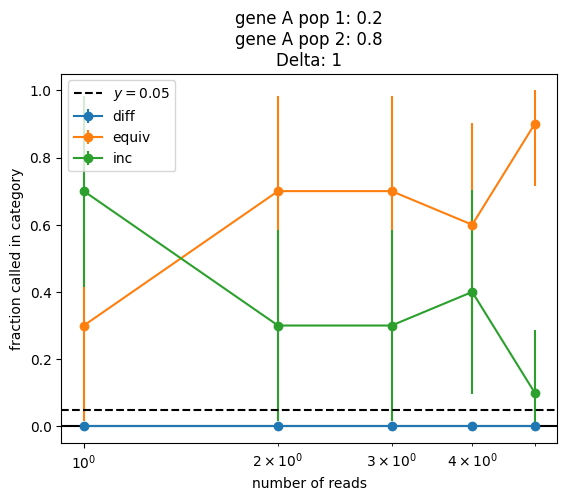

In [5]:
plt.errorbar(out["numReads"], out["frac_sig_diff"], yerr = [out["frac_sig_diff"] - out["frac_sig_diff_lower"],
            out["frac_sig_diff_upper"] - out["frac_sig_diff"] ], marker = "o", label = "diff")
plt.errorbar(out["numReads"], out["frac_sig_equiv"], yerr = [out["frac_sig_equiv"] - out["frac_sig_equiv_lower"],
            out["frac_sig_equiv_upper"] - out["frac_sig_equiv"] ], marker = "o", label = "equiv")
plt.errorbar(out["numReads"], out["frac_sig_inc"], yerr = [out["frac_sig_inc"] - out["frac_sig_inc_lower"],
            out["frac_sig_inc_upper"] - out["frac_sig_inc"] ], marker = "o", label = "inc")
plt.xscale("log")
plt.axhline(y=0.05, linestyle="--", color="k", label = "$y = 0.05$")
plt.axhline(y=0.0, color="k")

plt.legend()
plt.xlabel("number of reads")
plt.ylabel("fraction called in category")
plt.title("gene A pop 1: {}\ngene A pop 2: {}\nDelta: {}".format(geneA_fracs[0], geneA_fracs[1], delta))
plt.savefig("{}pop1_{}_pop2_{}_delt_{}.png".format(outpath, *geneA_fracs, delta),bbox_inches='tight')
plt.show()